## CAGE raw energy spectrum checker

This notebook is intended to complement `energy_cal.py`.  
We use the interactive mode to load a raw spectrum from a particular set of cycle files, and use it to pick out the raw locations of the peaks, which can then be added to `metadata/input_peaks.json` as input guesses.

Run this notebook using the `legend-base` Shifter image.  [Here are the instructions to set this up.](https://github.com/legend-exp/legend/wiki/Computing-Resources-at-NERSC)

In [1]:
# install user prerequisites
# !pip install ipympl==0.5.7 --user

# Use this at NERSC to get interactive plots.
# %matplotlib widget

import os, h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pygama import DataGroup, lh5
import pygama.analysis.histograms as pgh

#### >>> Users, set config here ! <<<
Set the query here to DataGroup to load files.  You may want to refer to `runDB.json` to see how to vary this.  Here we also set the energy parameter of interest. 

In [8]:
# fileDB query
# que = 'run==66 and cycle > 885'
que = 'run==60'

# energy estimator of interest
# etype = 'energy'
etype = 'trapEftp'

# lh5 table name
tb_in = 'ORSIS3302DecoderForEnergy/dsp'

# uncalibrated energy range
# xlo, xhi, xpb = 0, 3e6, 1000 #10000
xlo, xhi, xpb = 0, 10000, 1 #10  # good for trapEmax and trapEftp

# load the fileDB and make sure the entries exist
dg = DataGroup('$CAGE_SW/processing/cage.json', load=True)
dg.fileDB.query(que, inplace=True)
if len(dg.fileDB)==0:
    print('Error, no files found.  Check your query, and fileDB.h5.')

ecal_cols = ['run', 'cycle', 'skip', 'runtype', 'startTime', 'threshold', 'stopTime', 'runtime']
dg.fileDB[ecal_cols]

,run,cycle,skip,runtype,startTime,threshold,stopTime,runtime
838,60,840,False,alp,1.602111e+09,16.0,1.602113e+09,29.985067
839,60,841,False,alp,1.602113e+09,16.0,1.602115e+09,29.975351
840,60,842,False,alp,1.602115e+09,16.0,1.602117e+09,29.982877
841,60,843,False,alp,1.602117e+09,16.0,1.602119e+09,29.987740
842,60,844,False,alp,1.602119e+09,16.0,1.602120e+09,29.997601
843,60,845,False,alp,1.602120e+09,16.0,1.602122e+09,29.985982
844,60,846,False,alp,1.602122e+09,16.0,1.602124e+09,29.991980
845,60,847,False,alp,1.602124e+09,16.0,1.602126e+09,29.999852
846,60,848,False,alp,1.602126e+09,16.0,1.602128e+09,29.989732
847,60,849,False,alp,1.602128e+09,16.0,1.602129e+09,29.978323


#### Load data
Here we use DataGroup's fileDB to select files, retrieve DSP data,
and show some information about what we've selected.

In [9]:
# essentially the same code as in energy_cal::check_raw_spectrum

# load numpy arrays of uncalibrated energy
dsp_list = dg.lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
raw_data = lh5.load_nda(dsp_list, [etype], tb_in, verbose=False)

# get runtime
runtime_min = dg.fileDB['runtime'].sum()

# print columns of table
with h5py.File(dsp_list.iloc[0], 'r') as hf:
    print('\nLH5 columns:', list(hf[f'{tb_in}'].keys()))
    
# histogram energy data for this estimator and normalize by runtime
data = raw_data[etype]
hist, bins, var = pgh.get_hist(data, range=(xlo, xhi), dx=xpb)
bins = bins[1:] # trim zero bin, not needed with ds='steps'
hist_rt = np.divide(hist, runtime_min * 60)

print(f'\nRaw E: {etype}, {len(data)} cts, runtime: {runtime_min:.2f} min')


LH5 columns: ['A_10', 'AoE', 'ToE', 'bl', 'bl_sig', 'bl_slope', 'channel', 'dcr', 'energy', 'hf_max', 'lf_max', 'log_tail_fit_intercept', 'log_tail_fit_mean', 'log_tail_fit_slope', 'lot_tail_fit_sigma', 'timestamp', 'tp_0', 'tp_10', 'tp_20', 'tp_30', 'tp_40', 'tp_50', 'tp_60', 'tp_70', 'tp_80', 'tp_90', 'tp_96', 'tp_max', 'trapEftp', 'trapEmax', 'triE']

Raw E: trapEftp, 1127073 cts, runtime: 299.87 min


#### Create interactive spectrum

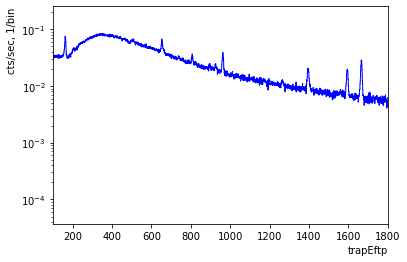

In [11]:
# %matplotlib widget
plt.semilogy(bins, hist_rt, ds='steps', c='b', lw=1, label=etype)
plt.xlabel(etype, ha='right', x=1)
plt.ylabel(f'cts/sec, {xpb}/bin', ha='right', y=1)
# plt.xlim(8000,1000000)
plt.xlim(100, 1800)
plt.show()

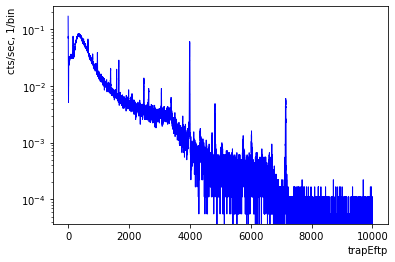

In [5]:
# draw a few lines in the uncalibrated spectrum

# %matplotlib widget
plt.semilogy(bins, hist_rt, ds='steps', c='b', lw=1, label=etype)

# plt.axvline(5120, c='r', lw=1)
# plt.axvline(1665, c='b', lw=1)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel(f'cts/sec, {xpb}/bin', ha='right', y=1)
plt.show()


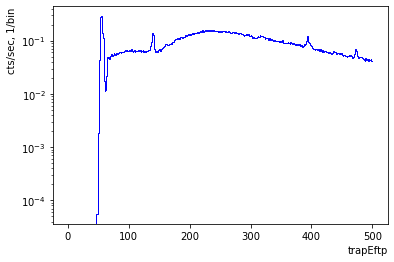

In [6]:
# apply an arbitrary set of calibration constants
# can be the output of np.polyfit

# pars = [-4.14621058e-06, 5.21111045e-01, 5.47450830e+01]
# pars = [ 4.79137964e-07, 9.98176163e-01, -4.24949030e-02]
pars = [0, 1, 0]
pars = [-4.28582919e-06, 5.20891424e-01, 5.47741940e+01]

xlo, xhi, xpb = 0, 500, 1
# xlo, xhi, xpb = 0, 100, 1

pfunc = np.poly1d(pars)
cal_data = pfunc(raw_data[etype])
hist, bins, var = pgh.get_hist(cal_data, range=(xlo, xhi), dx=xpb)
bins = bins[1:]
hist_rt = np.divide(hist, runtime_min * 60)

# %matplotlib widget

plt.semilogy(bins, hist_rt, ds='steps', c='b', lw=1, label=etype)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel(f'cts/sec, {xpb}/bin', ha='right', y=1)
plt.show()